In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy

import numpy as np
import os
from collections import Counter
from scipy.stats.distributions import chi2
from scipy.stats import binom_test
from scipy.stats import zscore

In [2]:
## Old (for ACL'19)
#ops_dir = "/hg191/corpora/legaldata/data/stats/"
#ops_features_file = os.path.join (ops_dir, "ops.feats_manual.complete")

ops_dir = "/hg191/corpora/semantic-progressiveness/legal-data/processed/"
ops_features_file = os.path.join (ops_dir, "ops.complete")

In [3]:
df_ops = pd.read_csv(ops_features_file)
print (len (df_ops))
print(df_ops['indeg'].max())
df_ops.head(3)

3854738
62255


,docid,indeg,outdeg,year,nuniqs,ntokens,bows,nprog,nreg,max_prog,...,nprog75,nprog50,nprog25,nreg99,nreg95,nreg90,nreg75,nreg50,nreg25,ninnovs
0,84581,3,0,1754,83,175,1.777650,0,0,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0
1,84581,3,0,1754,83,175,1.777650,0,0,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0
2,84582,2,0,1759,58,84,1.691117,0,0,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0


**Transform**
- Add an extra column for age.
- Add an extra column for not containing any semantic words.

In [4]:
df_ops["age"] = 2019 - df_ops["year"]
df_ops["isUNK"] = (df_ops["max_prog_word"] == "UNK").astype(int)
df_ops = df_ops[df_ops["year"] >= 1785]

In [5]:
# for simplicity of descriptive analysis, let's remove docs which don't hit the lexicon
# In the regression we will have to add a dummy variable to account for this.
drop_misses = True
if drop_misses:
    df_ops = df_ops[df_ops["isUNK"] == 0]
print (len(df_ops))

2624811


In [6]:
# quartile-ish bins of the innovation feature  
df_ops['max_prog_q'] = pd.qcut(df_ops['max_prog'],4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')

## Used to do this for ACL'19
#df_ops['nprog50_q'] = pd.qcut(df_ops['nprog50'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_ops['nprog90_q'] = pd.qcut(df_ops['nprog90'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_ops['nprog95_q'] = pd.qcut(df_ops['nprog95'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_ops['nprog99_q'] = pd.qcut(df_ops['nprog99'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")

In [7]:
def give_me_zscores_per_year (frame, key):
    years = frame.groupby("year").size().reset_index(name="counts")
    years = list (years[years["counts"] > 1].year.values)

    zscore_lookup = dict ()
    for year in years:
        docids = frame[frame["year"] == year]["docid"].values
        zscores = zscore (frame[frame["year"] == year][key].values)
        for i in range (len (docids)):
            zscore_lookup[docids[i]] = zscores[i]

    docids = frame["docid"].values
    zscores = [zscore_lookup[docid] for docid in docids]
    return zscores

df_ops['max_progz'] = give_me_zscores_per_year (df_ops, 'max_prog')
df_ops['max_progz_q'] = pd.qcut(df_ops['max_progz'], 4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')

**Univariate analysis**

In [8]:
df_ops_since_1980s = df_ops[(df_ops["year"] > 1980) & (df_ops["year"] <= 2010)]
print (len(df_ops_since_1980s))
#df_ops_since_1980s.to_csv ("../data/frames/emnlp/ops.univariate.csv", sep=",", index=False)

1399771


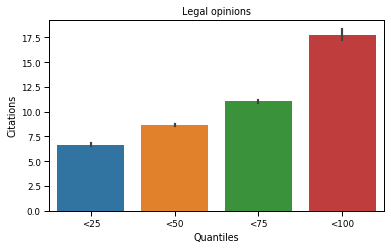

In [9]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='max_prog_q',data=df_ops_since_1980s,ax=ax);
ax.set_title('Legal opinions');
ax.set_xlabel('Quantiles');
ax.set_ylabel('Citations');

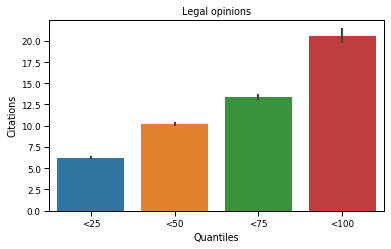

In [10]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='max_progz_q',data=df_ops_since_1980s,ax=ax);
ax.set_title('Legal opinions');
ax.set_xlabel('Quantiles');
ax.set_ylabel('Citations');

```python
# Old (did this for ACL' 19)
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='max_prog_q',data=df_ops_since_1980s,ax=ax);
ax.set_title('Legal opinions');
ax.set_xlabel('Quantiles');
ax.set_ylabel('Citations');
```

```python
# Old (did this for ACL' 19)
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5],sharey=False)

sns.barplot(y='indeg',x='nprog50_q',data=df_ops_since_1980s,ax=ax);
ax.set_title('>50 percentile')
ax.set_xlabel('Intervals')
ax.set_ylabel('Citations')
```

**Multivariate regressions**

In [11]:
formulas_ops = ["indeg ~ age + outdeg + ntokens + bows + ninnovs"]

formulas_ops.append(formulas_ops[0]+" + max_prog")
formulas_ops.append(formulas_ops[0]+" + max_prog_q")
formulas_ops.append(formulas_ops[0]+" + max_progz")
formulas_ops.append(formulas_ops[0]+" + max_progz_q")
#formulas_ops.append(formulas_ops[0]+" + nprog50")
#formulas_ops.append(formulas_ops[0]+" + nprog50_q")
#formulas_ops.append(formulas_ops[1]+" + nprog90")
#formulas_ops.append(formulas_ops[1]+" + nprog90_q")
#formulas_ops.append(formulas_ops[1]+" + nprog95")
#formulas_ops.append(formulas_ops[1]+" + nprog95_q")
#formulas_ops.append(formulas_ops[1]+" + nprog99")
#formulas_ops.append(formulas_ops[1]+" + nprog99_q")

In [12]:
df_ops_sample = df_ops.sample (n=25000, axis=0)

In [13]:
print(len(df_ops_sample[df_ops_sample["max_progz_q"] == "<25"]))
print(len(df_ops_sample[df_ops_sample["max_progz_q"] == "<50"]))
print(len(df_ops_sample[df_ops_sample["max_progz_q"] == "<75"]))
print(len(df_ops_sample[df_ops_sample["max_progz_q"] == "<100"]))
print(len(df_ops_sample))

6281
6340
6109
6270
25000


In [42]:
from scipy.stats import ks_2samp
years = range (1960, 2010)
x = [Counter(df_ops_sample[df_ops_sample["max_progz_q"] == "<25"].year.values)[y] for y in years]
y = [Counter(df_ops_sample[df_ops_sample["max_progz_q"] == "<100"].year.values)[y] for y in years]
#y = [item[1] for item in Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<50"].year.values).most_common(10)]
ks_2samp(x, y)

Ks_2sampResult(statistic=0.22, pvalue=0.17858668181221732)

In [29]:
print(x)
print(y)

[1, 0, 1, 1, 2, 5, 4, 2, 3, 3, 3, 3, 4, 1, 6, 4, 7, 5, 3, 6, 2, 5, 1, 11, 8, 10, 10, 20, 12, 13, 10, 13, 12, 8, 7, 11, 17, 9, 11, 18, 13, 7, 18, 9, 16, 14, 10, 8, 11, 13, 14, 18, 14, 19, 8, 15, 10, 17, 5, 7, 8, 17, 18, 11, 12, 8, 16, 13, 7, 26, 10, 22, 28, 30, 55, 24, 29, 61, 41, 40, 30, 40, 60, 62, 59, 40, 73, 90, 88, 89, 121, 123, 116, 100, 134, 137, 144, 151, 163, 192, 170, 158, 200, 194, 151, 218, 210, 225, 259, 222]
[12, 5, 14, 7, 9, 5, 5, 7, 10, 9, 12, 8, 22, 16, 5, 19, 11, 11, 11, 6, 13, 16, 15, 27, 28, 43, 57, 60, 40, 46, 53, 41, 36, 44, 40, 27, 38, 32, 34, 54, 35, 34, 34, 27, 24, 20, 22, 30, 26, 21, 23, 32, 17, 25, 31, 25, 18, 25, 23, 20, 26, 30, 27, 17, 24, 17, 18, 22, 26, 17, 30, 31, 24, 29, 37, 28, 36, 51, 42, 41, 41, 56, 45, 49, 61, 59, 60, 73, 68, 76, 67, 65, 90, 101, 101, 123, 110, 110, 115, 117, 133, 116, 125, 119, 138, 136, 141, 163, 153, 158]


```python
## Old (for ACL' 19): I don't think this is even required. We moved this into a separate script.

FROM=1980
TO=2010

#df_ops["logdeg"] = np.log1p(df_ops["indeg"])

sns.set_context ("paper")
fig,ax = plt.subplots (1,1, figsize=(6,1.8), sharey=False)
sns.barplot (y="indeg", x="nprog50_q", 
             data=df_ops_sample[(df_ops_sample["year"] > FROM) & (df_ops_sample["year"] <= TO)], 
             ax=ax, color='green',
             order=["<25", "<50", "<75", "<100"])
ax.set_title ("Legal opinions")
ax.set_ylabel ("Number of citations")
ax.set_xlabel ("Num progressiveness quantile")
```

In [78]:
results_ops = []
for formula in formulas_ops:
    Y,X = patsy.dmatrices(formula,data=df_ops_sample)
    results_ops.append(sm.GLM(Y, X, family=sm.families.Poisson()).fit())

In [79]:
lls = [result.llf for result in results_ops]
print(lls)
print (max(lls))

[-410601.43724993075, -410158.0165202357, -399593.39555124583, -406842.96235859056, -408030.8049823752]
-399593.39555124583


In [71]:
for i,ll_0 in enumerate(lls):
    for j,ll_1 in enumerate(lls[:i]):
        chi2_score = ll_0-ll_1
        dof = len(formulas_ops[i].split("+")) - len(formulas_ops[j].split('+'))
        if i == 3: dof += 2 #quartiles
        print(i,j,f'\\chi^2_{dof} = {chi2_score:.2f}, p < {chi2.sf(chi2_score, dof):.3e}')

1 0 \chi^2_1 = 464.50, p < 5.048e-103
2 0 \chi^2_1 = 5918.31, p < 0.000e+00
2 1 \chi^2_0 = 5453.81, p < nan
3 0 \chi^2_3 = 134.63, p < 5.432e-29
3 1 \chi^2_2 = -329.87, p < 1.000e+00
3 2 \chi^2_2 = -5783.67, p < 1.000e+00
4 0 \chi^2_1 = 2537.86, p < 0.000e+00
4 1 \chi^2_0 = 2073.36, p < nan
4 2 \chi^2_0 = -3380.45, p < nan
4 3 \chi^2_0 = 2403.23, p < nan


In [80]:
for i in range (len (results_ops)):
    print(results_ops[i].summary())
    print ()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  indeg   No. Observations:                25000
Model:                            GLM   Df Residuals:                    24994
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.1060e+05
Date:                Tue, 21 May 2019   Deviance:                   7.6693e+05
Time:                        19:08:01   Pearson chi2:                 4.65e+06
No. Iterations:                    16   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4210      0.004    350.356      0.000       1.413       1.429
age            0.0107   6.54e-05    163.930      0.0

In [82]:
df_ops_sample.to_csv ("../data/frames/emnlp/ops.final", sep=",", index=False)